<table style="border: none">
    <tr style="border: none">
    <td style="border: none">
        <img align="left" src="img/Woodmark_4c_zentriert.png" width=500 height=388>
    </td>
    <td style="border: none">
        <h1>House Price Challenge</h1>
        Kaggle Munich Meetup 2017-03-09
        <ul>
            <font size="3">
            <li>Wolfgang Moser <a href="mailto:wolfgang.moser@woodmark.de">wolfgang.moser@woodmark.de</a></li>
            <li>Frank Ditsche <a href="mailto:frank.ditsche@woodmark.de">frank.ditsche@woodmark.de</a></li>
            <li>Simon Heeg <a href="mailto:simon.heeg@woodmark.de">simon.heeg@woodmark.de</a></li>
            </font>
        </ul>
        <center><img align="center" src="img/kaggle_munich.png" width=200></center>
    </td>
    </tr>
</table>

## Libraries


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import skew
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from IPython.display import display

## Load input data

In [2]:
train = pd.read_csv("input/train.csv")
test = pd.read_csv("input/test.csv")

## Check data dimensions

In [3]:
print("Number of features in training set: {}".format(train.shape[1]))
print("Number of training data entries: {}".format(train.shape[0]))
print("Number of test data entries: {}".format(test.shape[0]))

Number of features in training set: 81
Number of training data entries: 1460
Number of test data entries: 1459


## Where is the ID / the training prices?

In [4]:
print("First column in both sets is: {}".format(train.columns[0]))
print("Last column in training set is: {}".format(train.columns[-1]))

First column in both sets is: Id
Last column in training set is: SalePrice


## What do the features look like?

In [5]:
train.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2008,WD,Normal,118000


In [6]:
fig, axs = plt.subplots(1,2,figsize=(17,7))

train['LotArea'].plot.density(ax=axs[0])
train['LotArea'].plot.density(ax=axs[1])

print("Max. lot area: {} ft²".format(train['LotArea'].max()))
print("Mean lot area: {:.2f} ft²".format(train['LotArea'].mean()))

Max. lot area: 215245 ft²
Mean lot area: 10516.83 ft²


In [7]:
axs[0].set_xlim([0,train['LotArea'].max()])
axs[0].set_xlabel("ft²")
axs[0].set_ylabel("density")

axs[1].set_xlim([30000,train['LotArea'].max()]); axs[1].set_ylim([0.,0.00000075])
axs[1].set_xlabel("ft²"); axs[1].set_ylabel("")

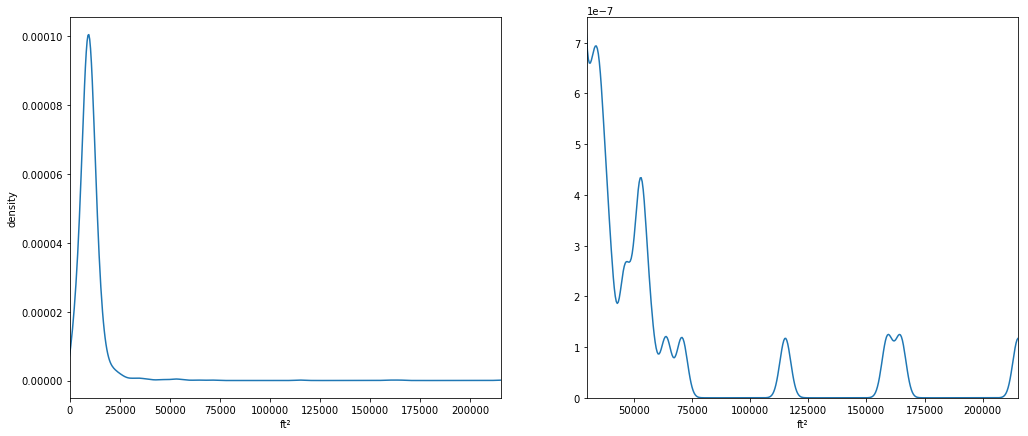

In [8]:
plt.show()

## Make index column the actual data frame index

In [9]:
train.set_index('Id', inplace=True)
test.set_index('Id', inplace=True)

## Split off the price column from the training data

In [10]:
train_price = train["SalePrice"]
train.drop("SalePrice", axis=1, inplace=True)

## Check value ranges of (numerical) features

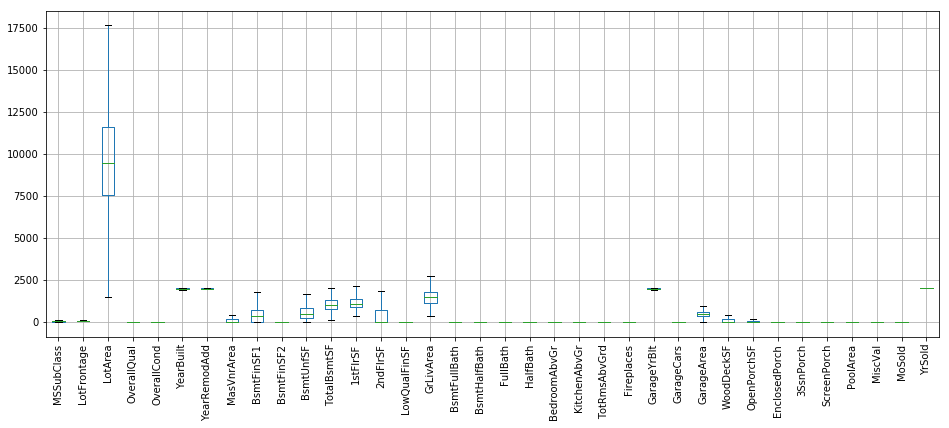

In [11]:
plt.rcParams['figure.figsize'] = (16, 6)
train.boxplot(showfliers=False, rot=90)
plt.show()

## Deal with numerical features first

In [12]:
# extract locations of numerical features
num_feat = (train.dtypes != "object").as_matrix()
print("Number of numerical features: {}".format(np.sum(num_feat)))
    
train_num = train.iloc[:, num_feat]
test_num = test.iloc[:, num_feat]

Number of numerical features: 36


### Check positivity and fill missing values with column means

In [13]:
print("All numerical values in training set positive? {}"
      .format(not (train_num < 0).any().any()))
# fill missing values in training set with column means
train_num = train_num.fillna(train_num.mean())
train.iloc[:, num_feat] = train_num

print("All numerical values in test set positive? {}"
      .format(not (test_num < 0).any().any()))
# fill missing values in test set with TRAINING column means
test_num = test_num.fillna(train_num.mean())
test.iloc[:, num_feat] = test_num

All numerical values in training set positive? True
All numerical values in test set positive? True


## Check skewness (third central moment)

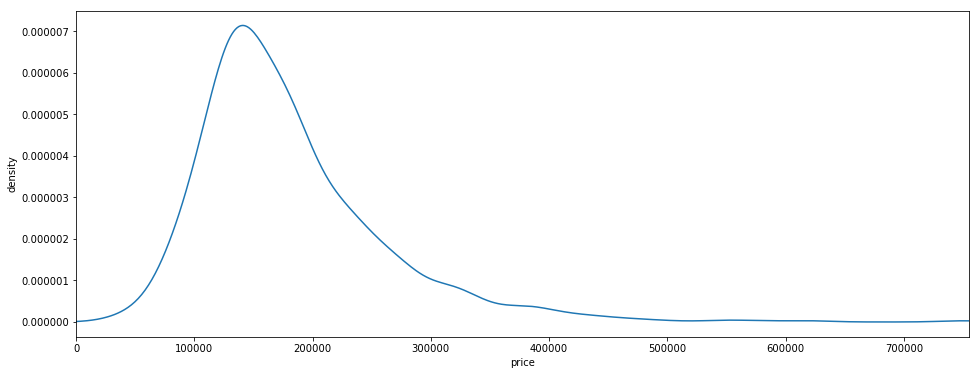

In [14]:
ax = train_price.plot.density()
ax.set_xlim([0,train_price.max()])
ax.set_xlabel("price")
ax.set_ylabel("density")
plt.show()

In [15]:
print("Numerical feature columns:")
display(train.columns[num_feat])
print("Skeweness of numerical training features:")
display(skew(train_num))

Numerical feature columns:


Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

Skeweness of numerical training features:


array([  1.40621011,   2.38249918,  12.19514213,   0.21672098,
         0.69235521,  -0.61283072,  -0.5030445 ,   2.67366126,
         1.6837709 ,   4.25088802,   0.9193227 ,   1.52268809,
         1.37534174,   0.81219427,   9.00208042,   1.36515595,
         0.59545404,   4.09918567,   0.03652398,   0.67520283,
         0.21157244,   4.48378409,   0.67564577,   0.64889763,
        -0.66748815,  -0.3421969 ,   0.17979594,   1.5397917 ,
         2.36191193,   3.08669647,  10.29375236,   4.11797738,
        14.81313466,  24.45163962,   0.21183506,   0.09616958])

## Log(1+p) transform of skewed features

In [16]:
skewed = (np.absolute(skew(train_num)) > 1)
train_num.iloc[:, skewed] = np.log1p(train_num.iloc[:, skewed])
test_num.iloc[:, skewed] = np.log1p(test_num.iloc[:, skewed])
train_price = np.log1p(train_price)

print("Skeweness of numerical training features after transformation:")
display(skew(train_num))

Skeweness of numerical training features after transformation:


array([  2.48741218e-01,  -8.91060059e-01,  -1.37263272e-01,
         2.16720977e-01,   6.92355214e-01,  -6.12830724e-01,
        -5.03044497e-01,   4.80625684e-01,  -6.17774284e-01,
         2.52110019e+00,   9.19322702e-01,  -5.14937258e+00,
         8.00317572e-02,   8.12194273e-01,   7.45264962e+00,
        -6.13394321e-03,   5.95454038e-01,   3.92902155e+00,
         3.65239844e-02,   6.75202835e-01,   2.11572442e-01,
         3.86543714e+00,   6.75645767e-01,   6.48897631e-01,
        -6.67488146e-01,  -3.42196895e-01,   1.79795942e-01,
         1.53378802e-01,  -2.33732497e-02,   2.11010418e+00,
         7.72702571e+00,   3.14717122e+00,   1.43483416e+01,
         5.16538998e+00,   2.11835060e-01,   9.61695796e-02])

## Normalize numerical features

In [17]:
scaler = StandardScaler().fit(train_num)
train_num = scaler.transform(train_num)
test_num = scaler.transform(test_num)

### Apply the transformed values to the orginial sets

In [18]:
train.iloc[:, num_feat] = train_num
test.iloc[:, num_feat] = test_num

## Transform categorical to numerical features

In [19]:
train_test = pd.concat([train, test])
train_test = pd.get_dummies(train_test)
train_test.iloc[:,40:].head(4)

,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1,0,0,1,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0
2,0,0,1,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0
3,0,0,1,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
4,0,0,1,0,0,1,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0


## Split sets again

In [20]:
train = train_test.iloc[:train.shape[0], :]
test = train_test.iloc[train.shape[0]:, :]

# Finally we can start with machine learning

## First try: __Linear Regression__

In [21]:
lin_reg = linear_model.LinearRegression()
scores = cross_val_score(lin_reg, train, train_price,
                         cv=5, scoring='neg_mean_squared_error')
print("Mean of 5 CV sqrt MSE: {:.4f}".format(np.sqrt(-scores.mean())))

Mean of 5 CV sqrt MSE: 1896891255.0944


## Second try: __Ridge Regression__

In [22]:
ridge = linear_model.Ridge(alpha=10.)
scores = cross_val_score(ridge, train, train_price,
                         cv=5, scoring='neg_mean_squared_error')
print("Mean of 5 CV sqrt MSE: {:.4f}".format(np.sqrt(-scores.mean())))

Mean of 5 CV sqrt MSE: 0.1279


Ridge Regression seems to work better!

## Fit estimator to training data

In [23]:
ridge.fit(train, train_price)

Ridge(alpha=10.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

### Apply estimator to test set and retransform predicted prices

In [24]:
preds = ridge.predict(test)

In [25]:
preds_price = np.expm1(preds)

### Prepare format for submission and save as CSV

In [26]:
test_results = pd.DataFrame({'SalePrice': preds_price,
                             'Id': test.index})
test_results.set_index('Id', inplace=True)

test_results.to_csv("output/test_results.csv")